In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a3cbaac9e8>,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08}

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

# Perform a query to retrieve the data and precipitation scores

results = session.query(Measurement.prcp, Measurement.date).\
    order_by((Measurement.date).desc()).\
    filter(Measurement.date >= '2016-01-01').filter(Measurement.date <= '2016-12-31').all()

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

df = pd.DataFrame(results, columns=['precipitation', 'date'])
df.set_index('date', inplace=True)
df.tail()

,precipitation
date,
2016-01-01,0.02
2016-01-01,0.00
2016-01-01,0.00
2016-01-01,0.02
2016-01-01,0.00


<IPython.core.display.Javascript object>


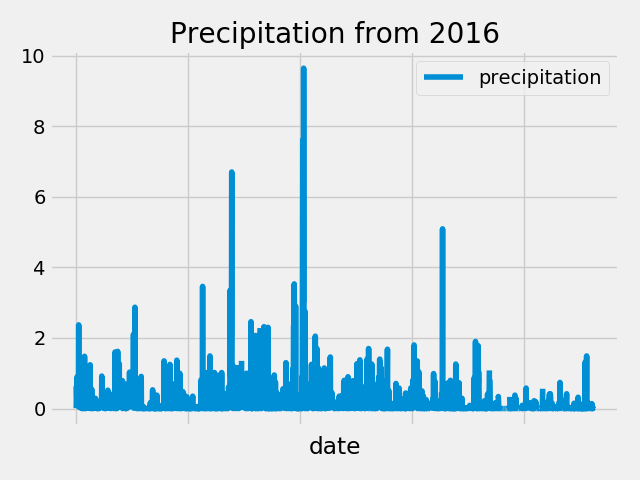

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates
df.plot(title = "Precipitation from 2016")
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2069.000000
mean,0.179845
std,0.506363
min,0.000000
25%,0.000000
50%,0.020000
75%,0.150000
max,9.640000


In [16]:
# How many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [17]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.tobs, Measurement.date).\
    order_by((Measurement.date).desc()).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= '2016-01-01').filter(Measurement.date <= '2016-12-31').all()

temp_df = pd.DataFrame(temp_results, columns=['temperature', 'date'])
temp_df.set_index('date', inplace=True)
temp_df.head()

,temperature
date,
2016-12-31,67.0
2016-12-30,69.0
2016-12-29,74.0
2016-12-28,72.0
2016-12-27,71.0


<IPython.core.display.Javascript object>


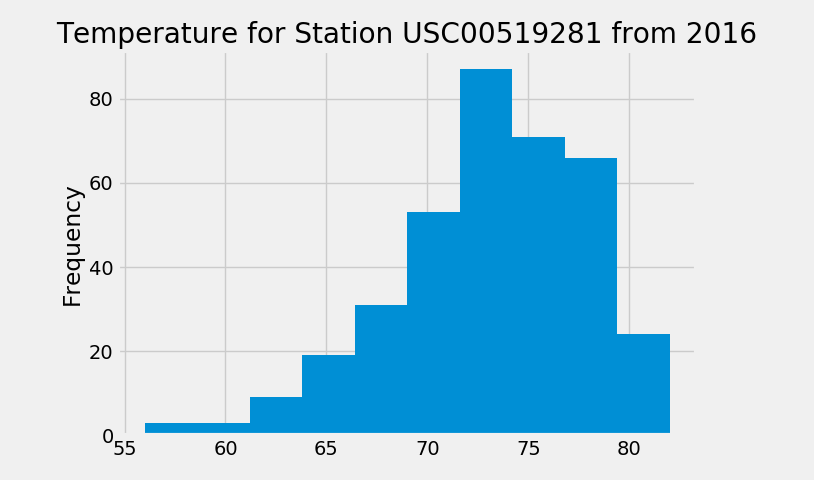

In [20]:
temp_df.hist()
plt.title("Temperature for Station USC00519281 from 2016")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [21]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps = calc_temps('2016-01-01', '2016-12-31')
print(calc_temps)

[(56.0, 74.14421827631008, 84.0)]


<IPython.core.display.Javascript object>


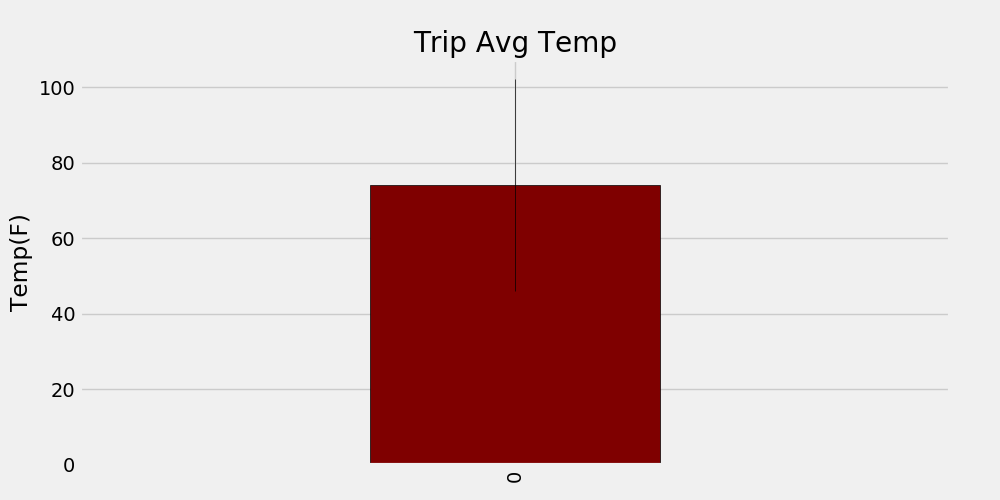

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
calc_temps_df = pd.DataFrame(calc_temps, columns=['min', 'avg', 'max'])
avg_temp = calc_temps_df["avg"]
yerr = calc_temps_df["max"]-calc_temps_df["min"]

avg_temp.plot(kind='bar',yerr=yerr,colormap='OrRd_r',edgecolor='black', error_kw=dict(ecolor='black',elinewidth=0.5),width=0.25, figsize=(10,5))
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.show()

In [24]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [25]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1a3cdca7780>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [26]:
def calc_rainful(start_date, end_date):
    return session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
            group_by(Measurement.station).\
            order_by((func.sum(Measurement.prcp)).desc()).\
            filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

rainful_by_station = calc_rainful('2016-01-01', '2016-12-31')
rainful_by_station

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1465.9199999999885),
 ('USC00519281',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  719.0099999999943),
 ('USC00513117',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  469.3499999999974),
 ('USC00519523',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  276.9299999999997),
 ('USC00514830',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  245.60999999999999),
 ('USC00519397',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  145.35000000000005),
 ('USC00517948',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  26.72999999999992)]

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
